## Data Analysis

### Import Modules

In [1]:
#Data Cleaning
import pandas as pd
import numpy as np
from scipy.stats import linregress
from scipy.stats import f_oneway

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sn
import gmaps



# Data Extraction
import requests
import json

# Import API key
from config import g_key
import gmaps.geojson_geometries

#test
from matplotlib.cm import viridis
from matplotlib.colors import to_hex



### Load Data from CSV

In [2]:
iso_cleaned_df = pd.read_csv('./Resources/isoDataFinal.csv')
vaccination_df = pd.read_csv('./Resources/iso_code.csv')

In [3]:
iso_cleaned_df.head(10)

,iso_code,Country,GDP,Total_Pop,Pop_Den,health_exp,Lat_avg,Lng_avg,total_vaccinations,people_fully_vaccinated_per_hundred
0,ALB,Albania,1.514702e+10,2866376.0,104.612263,44.657787,41.0000,20.0000,400064.0,0.02
1,AND,Andorra,3.218316e+09,77006.0,163.842553,32.065220,42.5000,1.6000,26414.0,6.06
2,ARE,United Arab Emirates,4.222150e+11,9630959.0,135.609110,48.421539,24.0000,54.0000,10336214.0,38.79
3,ARG,Argentina,5.176267e+11,44494502.0,16.258510,38.290127,-34.0000,-64.0000,7386650.0,1.95
4,AUT,Austria,4.550949e+11,8840521.0,107.131859,26.914829,47.3333,13.3333,2863389.0,8.73
5,AZE,Azerbaijan,4.711294e+10,9939771.0,120.257592,72.804810,40.5000,47.5000,1440243.0,4.87
6,BEL,Belgium,5.437344e+11,11427054.0,377.379590,24.215460,50.8333,4.0000,3563371.0,6.60
7,BGD,Bangladesh,2.740391e+11,161356039.0,1239.579312,76.501839,24.0000,90.0000,7954176.0,1.31
8,BGR,Bulgaria,6.623016e+10,7025037.0,64.711100,42.363476,43.0000,25.0000,750899.0,2.56
9,BHR,Bahrain,3.765250e+10,1569439.0,2012.101282,41.167648,26.0000,50.5500,1206763.0,31.14


### Split Data by Indicator quartiles

#### One Way ANOVA Test
* Null Hypothesis: Each sample mean for indicators broken down by quartile are equivalent
* Alternative Hypothesis: There exists one mean such that the sample mean for indicators are not all equivalent

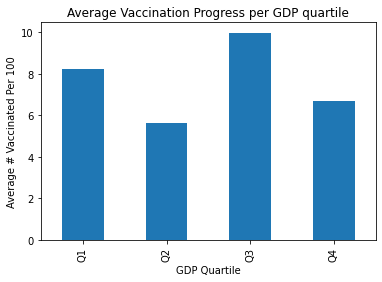

ANOVA: Fail to reject Null Hypothesis


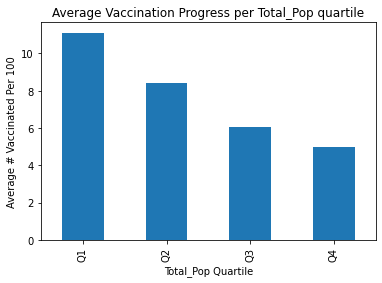

ANOVA: Fail to reject Null Hypothesis


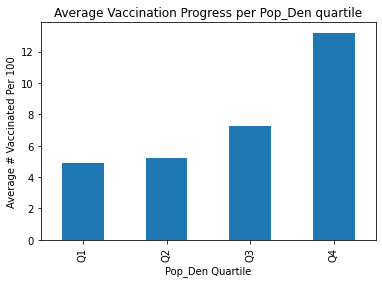

ANOVA: Pop_Den Reject Null Hypothesis


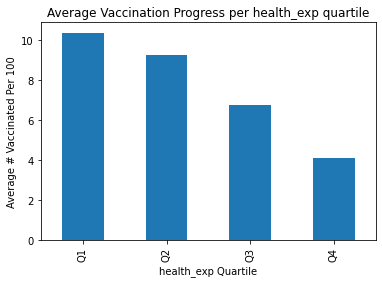

ANOVA: Fail to reject Null Hypothesis


In [4]:
# Group data by bins and look at mean vaccination
for i in ['GDP','Total_Pop','Pop_Den','health_exp']:
    #Cut data into quartiles based on indicators
    iso_cleaned_df[f'{i}_Bins'] = pd.qcut(iso_cleaned_df[i],4,labels=['Q1','Q2','Q3','Q4'])
    
    #Group by quartiles
    GroupObject = iso_cleaned_df.groupby(f'{i}_Bins')['people_fully_vaccinated_per_hundred']
    
    #Plot the average of the indicator grouped into quartiles
    GroupObject.mean().plot(kind='bar')
    plt.title(f'Average Vaccination Progress per {i} quartile')
    plt.xlabel(f'{i} Quartile')
    plt.ylabel(f'Average # Vaccinated Per 100')
    plt.savefig(f'./Resources/Output/{i}.vaccMean.png')
    plt.show()
    
    q1 = iso_cleaned_df[iso_cleaned_df[f'{i}_Bins']=='Q1']
    q2 = iso_cleaned_df[iso_cleaned_df[f'{i}_Bins']=='Q2']
    q3 = iso_cleaned_df[iso_cleaned_df[f'{i}_Bins']=='Q3']
    q4 = iso_cleaned_df[iso_cleaned_df[f'{i}_Bins']=='Q4']
   
    statistic, pvalue = f_oneway(q1['people_fully_vaccinated_per_hundred'],
             q2['people_fully_vaccinated_per_hundred'],
             q3['people_fully_vaccinated_per_hundred'],
             q4['people_fully_vaccinated_per_hundred']
            )
    alpha = 0.05
    if pvalue <= alpha:
        print(f'ANOVA: {i} Reject Null Hypothesis')
    else:
        print('ANOVA: Fail to reject Null Hypothesis')

Since we are able to reject the null hypothesis in the case of population density, we can say at least one mean vaccination percentage per density quartile is different.

In [5]:
iso_cleaned_df

,iso_code,Country,GDP,Total_Pop,Pop_Den,health_exp,Lat_avg,Lng_avg,total_vaccinations,people_fully_vaccinated_per_hundred,GDP_Bins,Total_Pop_Bins,Pop_Den_Bins,health_exp_Bins
0,ALB,Albania,1.514702e+10,2866376.0,104.612263,44.657787,41.0000,20.0000,400064.0,0.02,Q1,Q1,Q3,Q3
1,AND,Andorra,3.218316e+09,77006.0,163.842553,32.065220,42.5000,1.6000,26414.0,6.06,Q1,Q1,Q3,Q2
2,ARE,United Arab Emirates,4.222150e+11,9630959.0,135.609110,48.421539,24.0000,54.0000,10336214.0,38.79,Q3,Q2,Q3,Q3
3,ARG,Argentina,5.176267e+11,44494502.0,16.258510,38.290127,-34.0000,-64.0000,7386650.0,1.95,Q4,Q4,Q1,Q3
4,AUT,Austria,4.550949e+11,8840521.0,107.131859,26.914829,47.3333,13.3333,2863389.0,8.73,Q4,Q2,Q3,Q2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,TUR,Turkey,7.783819e+11,82319724.0,106.960129,22.617729,39.0000,35.0000,21678461.0,9.84,Q4,Q4,Q3,Q1
96,URY,Uruguay,5.959689e+10,3449299.0,19.708028,27.016809,-33.0000,-56.0000,1695351.0,15.95,Q2,Q1,Q1,Q2
97,USA,United States,2.058016e+13,326687501.0,35.713622,49.587131,38.0000,-97.0000,232407669.0,28.93,Q4,Q4,Q2,Q4
98,ZAF,South Africa,3.682889e+11,57792520.0,47.640752,44.066910,-29.0000,24.0000,292623.0,0.49,Q3,Q4,Q2,Q3


### Linear Regression for total vaccination percentage

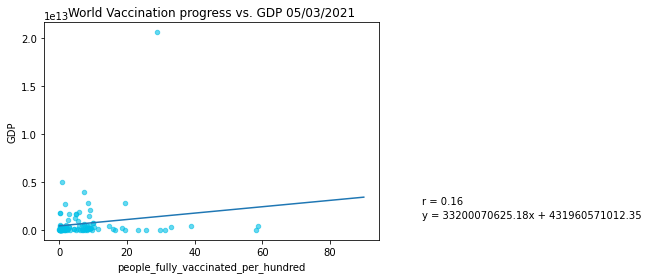

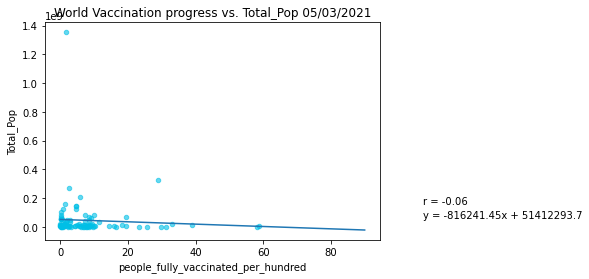

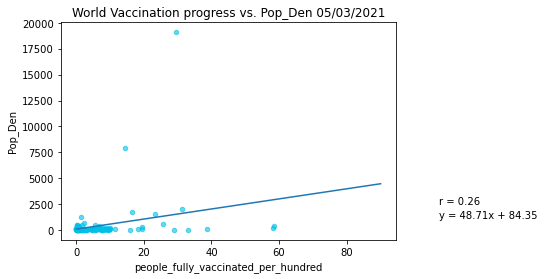

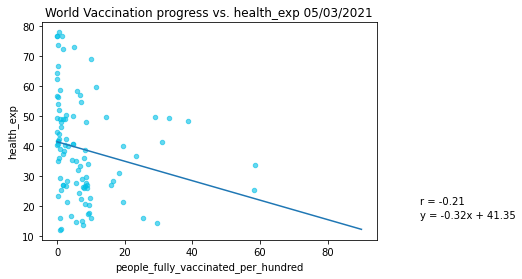

In [6]:
# Linear Regression for each data series compared to Vaccinations per 100 people
y_values = ['GDP','Total_Pop','Pop_Den','health_exp']
for metric in y_values:
    #
    x1 = iso_cleaned_df['people_fully_vaccinated_per_hundred']
    y1 = iso_cleaned_df[metric]
    analysisDate = '05/03/2021'
    
    #lin reg line
    slope, intercept, rvalue, pvalue, stderr = linregress(x1,y1)
    z = range(0,100,10)
    w = slope * z + intercept
    
    #Scatter plot and lin reg line
    fig, ax = plt.subplots()
    scatter = ax.scatter(x1, y1, s=20,color=(0,.75,.9),alpha=.6)
    
    plt.plot(z,w)
    plt.text(1,.25,f'r = {round(rvalue,2)}', transform=plt.gcf().transFigure)
    plt.text(1,.20,f'y = {round(slope,2)}x + {round(intercept,2)}', transform=plt.gcf().transFigure)
    
    #Formatting
    plt.title('World Vaccination progress vs. '+y1.name + ' '+ analysisDate)
    plt.xlabel(x1.name)
    plt.ylabel(y1.name)
    
    #Save figure and display
    plt.savefig(f'./Resources/Output/{x1.name}.{y1.name}Line.png')
    plt.show()

### Best and Worst performing countries in vaccine deployment in data set

In [7]:
x = iso_cleaned_df[['Country','people_fully_vaccinated_per_hundred']]
y = iso_cleaned_df[['Country','total_vaccinations']]

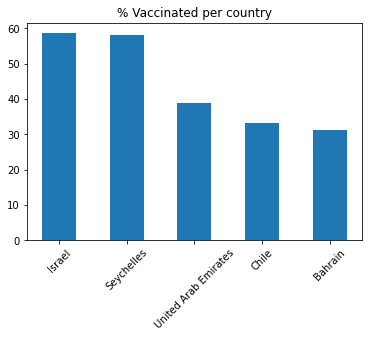

In [8]:
topVacc = x.sort_values(by='people_fully_vaccinated_per_hundred',ascending=False).head(5)
plt.bar(topVacc['Country'],topVacc['people_fully_vaccinated_per_hundred'],width=.5)
plt.title('% Vaccinated per country')
plt.xticks(rotation = 45)
plt.savefig('./Resources/Output/bestandworst/fig1.png')
plt.show()

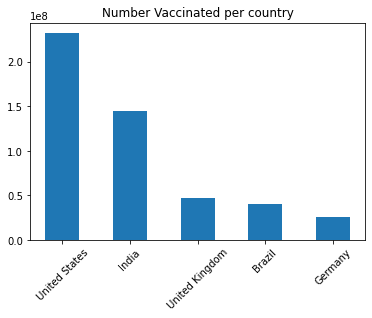

In [9]:
topTotal = y.sort_values(by='total_vaccinations',ascending=False).head(5)
plt.bar(topTotal['Country'],topTotal['total_vaccinations'],width=.5)
plt.title('Number Vaccinated per country')
plt.xticks(rotation = 45)
plt.savefig('./Resources/Output/bestandworst/fig2.png')
plt.show()

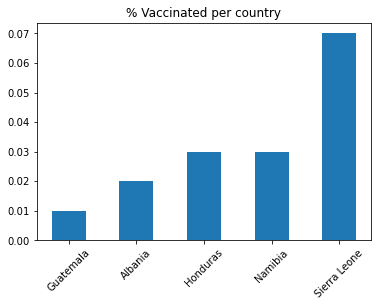

In [10]:
topVacc = x.sort_values(by='people_fully_vaccinated_per_hundred').head(5)
plt.bar(topVacc['Country'],topVacc['people_fully_vaccinated_per_hundred'],width=.5)
plt.title('% Vaccinated per country')
plt.xticks(rotation = 45)
plt.savefig('./Resources/Output/bestandworst/fig3.png')
plt.show()

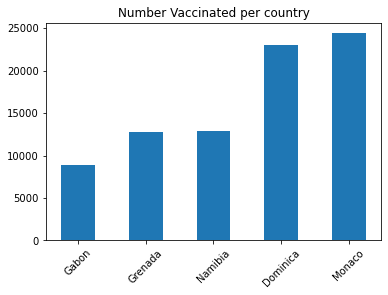

In [11]:
topTotal = y.sort_values(by='total_vaccinations').head(5)
plt.bar(topTotal['Country'],topTotal['total_vaccinations'],width=.5)
plt.title('Number Vaccinated per country')
plt.xticks(rotation = 45)
plt.savefig('./Resources/Output/bestandworst/fig4.png')
plt.show()

### Gmaps heatmap

In [12]:
iso_cleaned_df.sort_values(by='people_fully_vaccinated_per_hundred', ascending=False)

,iso_code,Country,GDP,Total_Pop,Pop_Den,health_exp,Lat_avg,Lng_avg,total_vaccinations,people_fully_vaccinated_per_hundred,GDP_Bins,Total_Pop_Bins,Pop_Den_Bins,health_exp_Bins
46,ISR,Israel,3.705880e+11,8882800.0,410.480591,33.555283,31.5000,34.7500,10468200.0,58.63,Q3,Q2,Q4,Q2
92,SYC,Seychelles,1.586009e+09,96762.0,210.352174,25.160439,-4.5833,55.6667,123831.0,58.21,Q1,Q1,Q4,Q1
2,ARE,United Arab Emirates,4.222150e+11,9630959.0,135.609110,48.421539,24.0000,54.0000,10336214.0,38.79,Q3,Q2,Q3,Q3
16,CHL,Chile,2.982580e+11,18729160.0,25.189447,49.161659,-30.0000,-71.0000,14324489.0,33.11,Q3,Q3,Q1,Q3
9,BHR,Bahrain,3.765250e+10,1569439.0,2012.101282,41.167648,26.0000,50.5500,1206763.0,31.14,Q2,Q1,Q4,Q3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,SLE,Sierra Leone,4.085115e+09,7650154.0,105.987171,64.410172,8.5000,-11.5000,57364.0,0.07,Q1,Q2,Q3,Q4
38,HND,Honduras,2.402419e+10,9587522.0,85.687032,56.705509,15.0000,-86.5000,57639.0,0.03,Q1,Q2,Q2,Q4
70,NAM,Namibia,1.345421e+10,2448255.0,2.973746,49.330338,-22.0000,17.0000,12833.0,0.03,Q1,Q1,Q1,Q4
0,ALB,Albania,1.514702e+10,2866376.0,104.612263,44.657787,41.0000,20.0000,400064.0,0.02,Q1,Q1,Q3,Q3


In [13]:
#create separate bins based on Population Density quartiles
#------>  This will allow us to adequately

q1_pop_dens_bin_df = iso_cleaned_df.loc[(iso_cleaned_df['Pop_Den_Bins']) == 'Q1']
q2_pop_dens_bin_df = iso_cleaned_df.loc[(iso_cleaned_df['Pop_Den_Bins']) == 'Q2']
q3_pop_dens_bin_df = iso_cleaned_df.loc[(iso_cleaned_df['Pop_Den_Bins']) == 'Q3']
q4_pop_dens_bin_df = iso_cleaned_df.loc[(iso_cleaned_df['Pop_Den_Bins']) == 'Q4']

In [14]:
#capture lat and long
country_heat= iso_cleaned_df[['Lat_avg', 'Lng_avg']]

vaccination_weight= iso_cleaned_df['people_fully_vaccinated_per_hundred']

In [15]:
#test test test test

gcountry_geojson = gmaps.geojson_geometries.load_geometry('countries')

#to get into test geo
# test_geojson

#                        !!!    list index is "row" in for loop we will use to add to new dictionary
#test_geojson['features'][0]['properties']['name']     produces afghanistan
#test_geojson['features'][0]['properties']['ISO_A3']     produces AFG   (Iso code)
#test_geojson['features'][0]

In [16]:
iso_cleaned_df['iso_code']         #VERIFY DTYPE

0     ALB
1     AND
2     ARE
3     ARG
4     AUT
     ... 
95    TUR
96    URY
97    USA
98    ZAF
99    ZWE
Name: iso_code, Length: 100, dtype: object

In [17]:
#try and create a geojson with only countries we grabbed

geojson_list_q1= []
geojson_list_q2= []
geojson_list_q3= []
geojson_list_q4= []


#Q1 Dictionary creation to add to test_countries_geojson_dict


#for loop
#                        !!!    list index is "row in for loop"
#test_geojson['features'][0]['properties']['name']     produces afghanistan
#test_geojson['features'][0]['properties']['ISO_A3']     produces AFG   (Iso code)


for row in gcountry_geojson['features']:
    country_iso = row['properties']['ISO_A3']      #may need to edit to [row] or [rowcount]
    add_geojson = row
    
    for index, x in enumerate(q1_pop_dens_bin_df['iso_code']):
        if x == country_iso:
            geojson_list_q1.append(add_geojson)
            
        else:
            pass
            
test_countries_geojson_dict_q1 = {'type': 'FeatureCollection',
                               'features': geojson_list_q1}


#Q2 Dictionary creation to add to test_countries_geojson_dict


#for loop
#                        !!!    list index is "row in for loop"
#test_geojson['features'][0]['properties']['name']     produces afghanistan
#test_geojson['features'][0]['properties']['ISO_A3']     produces AFG   (Iso code)


for row in gcountry_geojson['features']:
    country_iso = row['properties']['ISO_A3']      #may need to edit to [row] or [rowcount]
    add_geojson = row
    
    for index, x in enumerate(q2_pop_dens_bin_df['iso_code']):
        if x == country_iso:
            geojson_list_q2.append(add_geojson)
            
        else:
            pass
            
test_countries_geojson_dict_q2 = {'type': 'FeatureCollection',
                               'features': geojson_list_q2}


#Q3 Dictionary creation to add to test_countries_geojson_dict


#for loop
#                        !!!    list index is "row in for loop"
#test_geojson['features'][0]['properties']['name']     produces afghanistan
#test_geojson['features'][0]['properties']['ISO_A3']     produces AFG   (Iso code)


for row in gcountry_geojson['features']:
    country_iso = row['properties']['ISO_A3']      #may need to edit to [row] or [rowcount]
    add_geojson = row
    
    for index, x in enumerate(q3_pop_dens_bin_df['iso_code']):
        if x == country_iso:
            geojson_list_q3.append(add_geojson)
            
        else:
            pass
            
test_countries_geojson_dict_q3 = {'type': 'FeatureCollection',
                               'features': geojson_list_q3}


#Q4 Dictionary creation to add to test_countries_geojson_dict


#for loop
#                        !!!    list index is "row in for loop"
#test_geojson['features'][0]['properties']['name']     produces afghanistan
#test_geojson['features'][0]['properties']['ISO_A3']     produces AFG   (Iso code)


for row in gcountry_geojson['features']:
    country_iso = row['properties']['ISO_A3']      #may need to edit to [row] or [rowcount]
    add_geojson = row
    
    for index, x in enumerate(q4_pop_dens_bin_df['iso_code']):
        if x == country_iso:
            geojson_list_q4.append(add_geojson)
            
        else:
            pass
            
test_countries_geojson_dict_q4 = {'type': 'FeatureCollection',
                               'features': geojson_list_q4}

In [18]:
#verify it works
#geojson_list
#test_countries_geojson_dict

In [19]:
#plot heatmap with gmaps

#set country boundaries with geo json
#countries_geojson = gmaps.geojson_geometries.load_geometry('countries')

fig = gmaps.figure()

chloropleth_layer_q1 = gmaps.geojson_layer(test_countries_geojson_dict_q1, fill_color='red', stroke_color='red', fill_opacity=0.5)
chloropleth_layer_q2 = gmaps.geojson_layer(test_countries_geojson_dict_q2, fill_color='blue', stroke_color='blue', fill_opacity=0.4)
chloropleth_layer_q3 = gmaps.geojson_layer(test_countries_geojson_dict_q3, fill_color='yellow', stroke_color='yellow', fill_opacity=0.5)
chloropleth_layer_q4 = gmaps.geojson_layer(test_countries_geojson_dict_q4, fill_color='green', stroke_color='green', fill_opacity=0.5)






#create heat layer on top of gmaps
#make weight of heatmap reflect Vaccination per hundred people
heat_layer= gmaps.heatmap_layer(country_heat, weights=vaccination_weight, dissipating=False, max_intensity=30, point_radius=2.4)

#add layer to figure
fig.add_layer(chloropleth_layer_q1)
fig.add_layer(chloropleth_layer_q2)
fig.add_layer(chloropleth_layer_q3)
fig.add_layer(chloropleth_layer_q4)
fig.add_layer(heat_layer)

#Display combined
fig

Figure(layout=FigureLayout(height='420px'))